In [409]:
# %%html
# <style> .container {width:95%} .CodeMirror {font-family: Menlo; font-size: 9pt} .output {font-size: 9pt} </style>

In [234]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [328]:
# hyper parameters

scenarioStrings = {
  's1': 'Balanced panel',
  's2': 'Cond. on SPF nowcast',
  's3': 'Cond. on current-quarter data',
  's4': 'Full conditioning',
};

sourceColors = {
    'Pre-crisis': 'blue',
    'Post-crisis': 'red',
    'GLP': 'green',
    'Actual': 'black',
    'SPFMean': 'saddlebrown',
    'SPFIndividual': 'grey',
}

sourceWidths = {
    'Actual': 3,
    'SPFMean': 3,
    'SPFIndividual': 1,
    'Post-crisis models avg': 3,
    'Pre-crisis models avg': 3,
    'Pre-crisis': 1.5, # class of models
    'Post-crisis': 1.5, # class of models
    'GLP': 1.5 # class of models
}

topCandidateColors = {
    'CMR14': 'violet',
}

nberRecessionQuarters = ['2001Q1', '2001Q2', '2001Q3', '2008Q1', '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2020Q1', '2020Q2',]

In [329]:
quarters = ['1950Q1']

i = 0
while i < 500:
    
    lastQuarter = quarters[-1]
    if lastQuarter[-1] == '4':
        quarters.append(str(int(lastQuarter[0:4]) + 1) + 'Q1')
    else:
        quarters.append(lastQuarter[:-1] + str(int(lastQuarter[-1])+1))
        
    
    i += 1
    
quarters = [quarter[2:] for quarter in quarters]

In [330]:
modelClasses = {}

with open('../application/src/results.json') as j:
    results = json.load(j)
    
actual = {instance['vintageQuarter']: instance['actual']['gdp'] for instance in results['actual']}

external = {}
i = 0
for instance in results['external']:
    if instance['vintageQuarter'] in external.keys():
        if instance['model'] in external[instance['vintageQuarter']].keys():
            external[instance['vintageQuarter']][instance['model']+str(i)] = instance['forecast']['gdp']
            i += 1
        else:
            external[instance['vintageQuarter']][instance['model']] = instance['forecast']['gdp']
    else:
        external[instance['vintageQuarter']] = {instance['model']: instance['forecast']['gdp']}
        
ts = {}
for instance in results['ts']:
    try:
        ts[instance['vintageQuarter'] + instance['scenario']][instance['model']] = instance['forecast']['gdp']
    except:
        ts[instance['vintageQuarter'] + instance['scenario']] = {instance['model']: instance['forecast']['gdp']}
        
dsge = {}
for instance in results['dsge']:
    if 'vintageQuarter' not in instance.keys():
        instance['vintageQuarter'] = str(pd.to_datetime(instance['vintage']).to_period('Q'))
    if 'scenario' not in instance.keys():
        for scenario in [1,2,3,4]:
            try:
                dsge[instance['vintageQuarter'] + str(scenario)][instance['model']] = instance['forecast']['gdp']
            except:
                dsge[instance['vintageQuarter'] + str(scenario)] = {instance['model']: instance['forecast']['gdp']}

            modelClasses[instance['model']] = instance['ModelClass']
    
    else:
        try:
            dsge[instance['vintageQuarter'] + instance['scenario']][instance['model']] = instance['forecast']['gdp']
        except:
            dsge[instance['vintageQuarter'] + instance['scenario']] = {instance['model']: instance['forecast']['gdp']}

        modelClasses[instance['model']] = instance['ModelClass']

In [405]:
def plotForecasts(forecastStartQuarters, sources, topCandidates, scenarios, forecastHorizon):
    fig, axes = plt.subplots(
        len(scenarios), len(forecastStartQuarters), squeeze=False, sharex=False, sharey=False, figsize=(5*len(forecastStartQuarters),5))
    
    for s, scenario in enumerate(scenarios):
        for q, quarter in enumerate(forecastStartQuarters):
            ax = axes[s, q]
            
            # actual GDP
            gdpLastQuarter = external[quarter]['SPFMean'][0]
            ax.plot(range(forecastHorizon+1), [gdpLastQuarter] + actual[quarter][:forecastHorizon], label='Actual', color=sourceColors['Actual'], linewidth=sourceWidths['Actual'])
            
            # SPF data
            SPFIndividualLegend = False
            if 'SPFIndividual' in sources:
                for key, value in external[quarter].items():
                    if 'SPFIndividual' in key:
                        if SPFIndividualLegend == False:
                            ax.plot(range(forecastHorizon+1), external[quarter][key][:forecastHorizon+1], label='SPFIndividual', color=sourceColors['SPFIndividual'], linewidth=sourceWidths['SPFIndividual'], alpha=0.3)
                            SPFIndividualLegend = True
                        else:
                            ax.plot(range(forecastHorizon+1), external[quarter][key][:forecastHorizon+1], color=sourceColors['SPFIndividual'], linewidth=sourceWidths['SPFIndividual'], alpha=0.3)
                        
            if 'SPFMean' in sources:
                ax.plot(range(forecastHorizon+1), external[quarter]['SPFMean'][:forecastHorizon+1], label='SPFMean', color=sourceColors['SPFMean'], linewidth=sourceWidths['SPFMean'])
            
            # GLP
            for source in sources:
                if 'GLP' in source:
                    ax.plot(range(forecastHorizon+1), ts[quarter+scenario][source][:forecastHorizon+1], label=source, color=sourceColors['GLP'], linewidth=sourceWidths['GLP'])
            
            # All other sources
            for source in set(sources).difference({'SPFIndividual', 'SPFMean', 'GLP3v', 'GLP5v', 'GLP8v'}):
                width, color = '', ''
                
                if source in sourceWidths.keys():
                    width = sourceWidths[source]
                else:
                    width = sourceWidths[modelClasses[source]]

                if source in topCandidates:
                    color = topCandidateColors[source]
                else:
                    color = sourceColors[modelClasses[source]]

                ax.plot(range(forecastHorizon+1), dsge[quarter+scenario][source][:forecastHorizon+1], label=source, color=color, linewidth=width)
            
            # styling
            ax.set_title(f'{quarter}, {scenarioStrings[scenario]}', fontsize=14)
            ax.set_xlim([0, forecastHorizon])
            ax.set_ylim([-8, 6])
            ax.fill_between([0,3], -8, 6, color='grey', alpha=0.1)
            ax.spines['top'].set_color('grey')
            ax.spines['bottom'].set_color('grey')
            ax.spines['left'].set_color('grey')
            ax.spines['right'].set_color('grey')
            ax.grid()
            
            # horizontal axis labels
            index = quarters.index(quarter[2:]) - 1
            ax.set_xticklabels(quarters[index:index+forecastHorizon+1])
                        
    # legend
    ax.legend(ncol=len(sources) // 2 + 1, bbox_to_anchor=(0.6, 1.3))
    
    fig.tight_layout()
    return fig, axes

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

/var/folders/s7/nkrp8sg96dbc18n8td16qpqw0000gn/T/ipykernel_772/2940805692.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarters[index:index+forecastHorizon+1])
/var/folders/s7/nkrp8sg96dbc18n8td16qpqw0000gn/T/ipykernel_772/2940805692.py:66: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


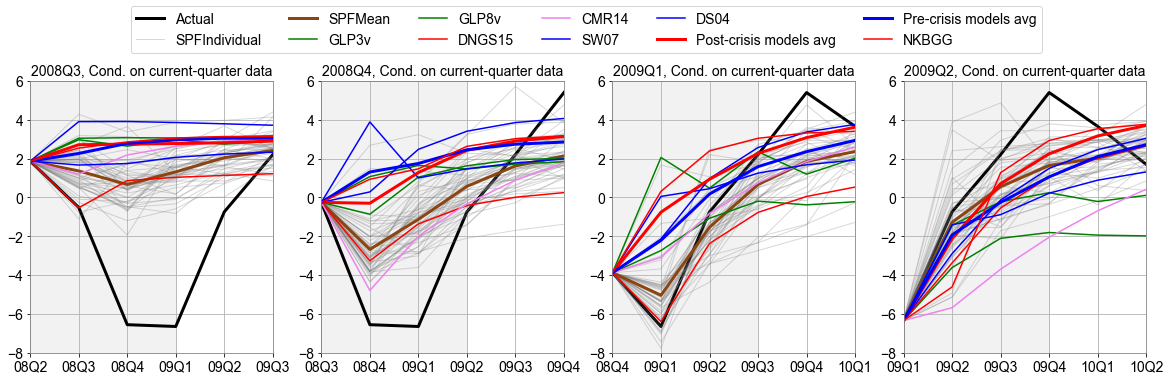

In [408]:
a, _ = plotForecasts(forecastStartQuarters=['2008Q3', '2008Q4', '2009Q1', '2009Q2'], 
                     sources=['SPFIndividual', 'SPFMean', 'CMR14', 'DNGS15', 'NKBGG', 'SW07', 'DS04', 'GLP3v', 'GLP8v', 'Post-crisis models avg', 'Pre-crisis models avg'], 
                     topCandidates = ['CMR14'],
                     scenarios=['s3'],
                     forecastHorizon=5)

a.savefig('aa.svg')

In [ ]:
# Pre-crisis models默認藍色，Post-crisis models默認紅色
# 如果對某些model需要不一樣的顏色，則需要在topCandidates中添加model names，並且在topCandidateColors中設定這些models的顏色
# 在一行四個charts的排列下，Legend的位置是合適的，但如果改變每行charts的數目，則Legend的位置會不再合適，需要調整“bbox_to_anchor=(0.6, 1.3)”的參數
# 保存圖片為svg格式，也就是可以放大不失真的矢量圖